In [1]:
import numpy as np
import os
import math
from glob import glob
import re
import json
from matplotlib import pyplot as plt

In [2]:
from model.MultiResUNet3D import MultiResUnet3D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence
import keras.backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

In [4]:
n_classes = 2
chanels = 1
batch_size = 1
mask_size = np.array([64, 64, 64])

In [5]:
def get_data_mask(path):
    file = np.load(path)
    vol = file['vol']
    mask = file['mask']
    file.close()
    if vol.shape[0] != 64 and vol.shape[1] != 64 and vol.shape[2] != 64:
        pad_value = np.array([64,64,64]) - vol.shape
        pad_value = np.array([[0,0,0], pad_value]).T
        vol = np.pad(vol, pad_value, mode='reflect')
        mask = np.pad(mask, pad_value, mode='reflect')
    return vol, mask

In [6]:
class Sequence_data(Sequence):

    def __init__(self, data, batch_size):
        # recive una lista de rutas de donde están los volumenes como numpy arrays y el batch_size
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # lista de rutas para el batch actual
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        y = []
        
        # se cargan los volumenes y las mascaras en sus respectivos arrays
        for path in batch_x:
            data, mask = get_data_mask(path)
            X.append(data)

            temp = to_categorical(mask)
            y.append(temp)
            
        X = np.array(X)
        y = np.array(y)
        
        try:
            resahped = X.reshape(-1, mask_size[0], mask_size[1], mask_size[2], chanels), y.reshape(-1, mask_size[0], mask_size[1], mask_size[2], n_classes)
        except:
            print(batch_x)
        return resahped
    
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.constant(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
    
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [7]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [8]:
paths_train = glob('./augmented/train/*.npz')
paths_test = glob('./augmented/test/*.npz')

In [9]:
seq_train = Sequence_data(paths_train, batch_size)
seq_test = Sequence_data(paths_test, batch_size)

In [10]:
model = MultiResUnet3D(mask_size[0], mask_size[1], mask_size[2], chanels, n_classes)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.compile(optimizer='Adadelta', loss=dice_coef_loss, metrics=['acc',jaccard_distance, dice_coef])

In [12]:
ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
MCP = ModelCheckpoint(filepath="./weights_aug/weights.{epoch:02d}.hdf5", save_best_only=True, save_weights_only=True)
callbacks = [ES, MCP]

In [ ]:
history = model.fit_generator(seq_train, validation_data=seq_test, steps_per_epoch=int(len(paths_train)/batch_size), epochs=200, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
102864/102864 [==============================] - 53175s 517ms/step - loss: 0.4526 - acc: 0.9863 - jaccard_distance: 0.5045 - dice_coef: 0.5474 - val_loss: 0.5686 - val_acc: 0.9965 - val_jaccard_distance: 0.4610 - val_dice_coef: 0.4314
Epoch 2/200
  3775/102864 [>.............................] - ETA: 14:38:05 - loss: 0.3585 - acc: 0.9959 - jaccard_distance: 0.4855 - dice_coef: 0.6415

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_distance'])
plt.plot(history.history['val_jaccard_distance'])
plt.title('jaccard_distance')
plt.ylabel('jaccard_distance')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib

def plot_vol(vol, mask):
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    
    max_index = mask.max()

    ax.imshow(vol[0], cmap="gray")
    ax.imshow(mask[0], cmap="gray", alpha=0.6, vmax=max_index, vmin=0)

    axslides  = plt.axes([0.25, 0.15, 0.65, 0.03])
    sfreq = Slider(axslides, 'image_n', 0, len(vol)-1, valstep=1)

    def update(val):
        ax.imshow(vol[int(sfreq.val)], cmap="gray")
        ax.imshow(mask[int(sfreq.val)], cmap="gray", alpha=0.6, vmax=max_index, vmin=0)
        fig.canvas.draw_idle()

    sfreq.on_changed(update)

In [17]:
vol, mask = get_data_mask('./sin_aumentar/test/0_0748_1.npz')

In [18]:
pred = model.predict(vol[np.newaxis, ..., np.newaxis])[0]

<IPython.core.display.Javascript object>


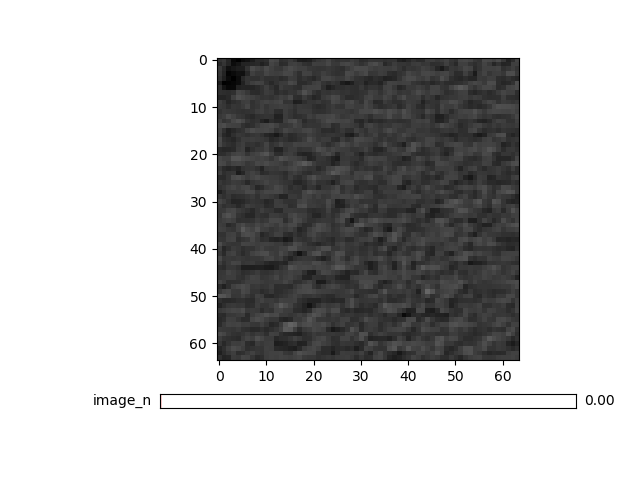

In [36]:
%matplotlib notebook
plot_vol(vol, pred[..., 1])